## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

from transformers.models.whisper import WhisperTokenizerFast
from datasets import load_from_disk

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP
from evaluation.string_edit_metrics import get_string_edit_metrics_ortho_and_norm
from normalization.whisper_normalization import get_whisper_normalizer
from utils.whisper_hallucinations.get_features import add_features_to_ds, compute_gzip_compression_ratio
from utils.whisper_hallucinations.eval_filter_criterion import eval_filter_criterion
from utils.notebook_utils import listen_to_audio

sns.set_theme(context="paper", style="ticks")

OUTPUT_DIR = Path("notebooks/outputs/8_1_best_kd/ami_100h")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## User input

In [4]:
load_from_pickle = True

pickle_filepath = "notebooks/data/ami_100h_medium_cached_33p.pkl"
ds_dirpath = "/home/tw581/rds/hpc-work/ami_100h_medium_cached_33p"

## Load tokenizer

In [5]:
pretrained_model_name_or_path = "openai/whisper-tiny"
tokenizer = WhisperTokenizerFast.from_pretrained(pretrained_model_name_or_path, language="english", task="transcribe")

## Load data

In [6]:
LIST_FEATURES = [
    'text',
    'teacher_text',
    'n_instant_tokens',
    'max_subarray_length',
    'audio_length',
    'n_tokens_labels',
    'n_tokens_teacher',
    'diff_n_tokens',
    'gzip_ratio',
    'teacher_gzip_ratio',
    'diff_gzip_ratio'
]

if load_from_pickle:
    df = pd.read_pickle(pickle_filepath)
else:
    ds = load_from_disk(ds_dirpath)
    ds = ds.map(lambda x: {"teacher_text": tokenizer.decode(x["teacher_sequences"], skip_special_tokens=True)})
    ds = add_features_to_ds(ds)
    df = pd.DataFrame({col: ds[col] for col in ds.features.keys() if col in LIST_FEATURES})
    df.to_pickle(pickle_filepath)

In [7]:
df.head()

,text,teacher_text,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio,n_instant_tokens,max_subarray_length
0,if you if you s. s. h. and they have this big ...,"If you ask this agent, they have this big war...",4.21,33,30,-3,1.084211,1.041237,-0.042973,22,23
1,i've gotten mm hardly any,Hardly any.,1.63,11,9,-2,0.555556,0.375000,-0.180556,5,6
2,it's yeah i mean the wave data are obviously n...,because the wave data are obviously not going...,5.25,23,22,-1,0.929412,0.914634,-0.014778,13,12
3,yeah it'll it'll play them in some order in wh...,"Yeah, it'll play them in some order in which ...",6.37,30,33,3,1.118812,1.075472,-0.043340,26,27
4,yeah,Yeah.,0.37,6,7,1,0.166667,0.230769,0.064103,4,4


In [8]:
df.sort_values("n_tokens_teacher", ascending=False)[:10]

,text,teacher_text,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio,n_instant_tokens,max_subarray_length
69,so then you'd start with all your utterances h...,so then you start with all your utterances he...,7.80,40,231,191,1.377551,6.910891,5.533340,219,102
5910,well 'cause sometimes they go you know like th...,"Because sometimes they go, uh, uh, uh, uh, uh...",7.27,36,227,191,1.145631,8.500000,7.354369,218,88
9120,uh,Mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm...,1.54,6,226,220,0.090909,16.444445,16.353535,216,81
19881,for instance um let's say oh oh um,"for instance, let's see, oh, oh, oh, oh, oh, ...",6.30,14,226,212,0.666667,9.060000,8.393333,217,88
12856,mm-hmm,Heheheheheheheheheheheheheheheheheheheheheheh...,1.61,8,226,218,0.230769,28.483871,28.253101,217,84
16133,well no no,"No, no, no, no, no, no, no, no, no, no, no, n...",1.23,8,226,218,0.357143,14.766666,14.409524,217,147
8571,no no no no no no no,No no no no no no no no no no no no no no no ...,1.13,12,226,214,0.800000,22.100000,21.300001,219,116
22414,s,"So, so, so, so, so, so, so, so, so, so, so, s...",1.80,6,226,220,0.047619,14.766666,14.719048,217,58
13284,mm-hmm,Heheheheheheheheheheheheheheheheheheheheheheh...,3.07,8,226,218,0.230769,28.483871,28.253101,217,112
28013,uh,Uhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh...,1.63,6,226,220,0.090909,29.400000,29.309090,215,59


## First analysis

In [9]:
dict_string_edit_metrics = get_string_edit_metrics_ortho_and_norm(references=df["text"], predictions=df["teacher_text"], norm_fn=get_whisper_normalizer("english"))

dict_string_edit_metrics

{'WER ortho (%)': 41.48708147035735,
 'Sub ortho (%)': 28.378101641694254,
 'Del ortho (%)': 11.354653742448548,
 'Ins ortho (%)': 1.7543260862145464,
 'WER (%)': 16.122473792283586,
 'Sub (%)': 5.124689289960013,
 'Del (%)': 9.102453258402681,
 'Ins (%)': 1.8953312439208905}

**Observation:** Using the Whisper normalizer drastically decreased the different string edit metric errors. Since 1-best operated without any normalization, we will focus on the orthographic WER in this study.

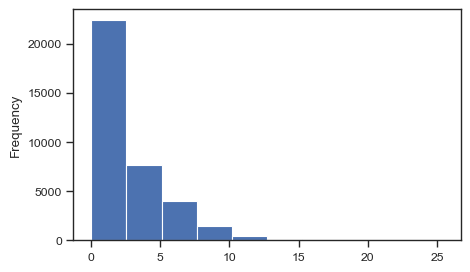

In [10]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

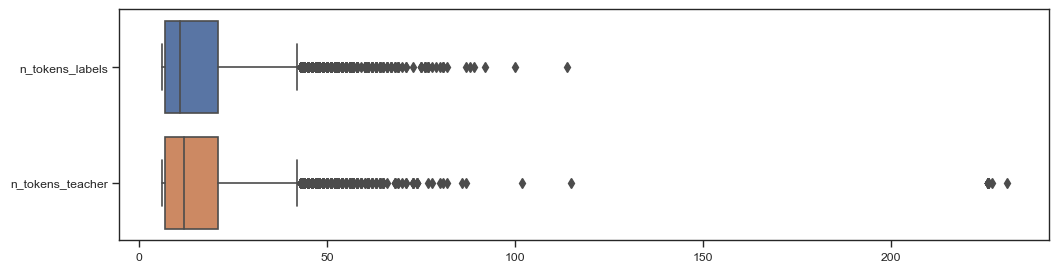

In [11]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=df[["n_tokens_labels", "n_tokens_teacher"]], orient="h");

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/analysis/n_tokens_teacher_wrt_n_tokens_label-ami.png`.


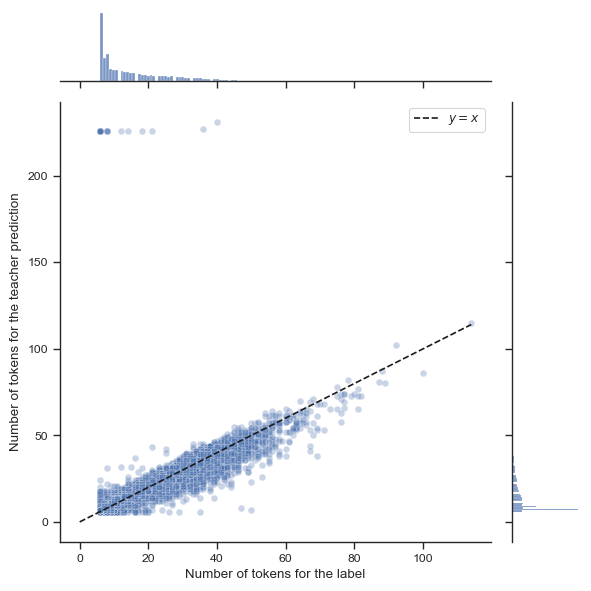

In [12]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'k--', label=r"$y=x$")
plt.legend()
plt.xlabel("Number of tokens for the label")
plt.ylabel("Number of tokens for the teacher prediction")
plt.tight_layout()

savepath = OUTPUT_DIR / "analysis" / "n_tokens_teacher_wrt_n_tokens_label-ami.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [13]:
df["diff_n_tokens"].describe().to_frame()

,diff_n_tokens
count,36164.000000
mean,0.382729
std,5.526085
min,-43.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,220.000000


In [14]:
df["diff_n_tokens_50+"] = (df["diff_n_tokens"] > 50)
df["diff_n_tokens_50+"].value_counts() / len(df)

False    0.999475
True     0.000525
Name: diff_n_tokens_50+, dtype: float64

In [15]:
df_candidates = df[df["diff_n_tokens_50+"]]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 69
Reference:  so then you'd start with all your utterances here and when you go up to get topic segments you go to here here here here here here here
Prediction:   so then you start with all your utterances here and when you go up to get topic segments you go to here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here

Idx = 5910
Reference:  well 'cause sometimes they go you know like that and then you're not really sure whether it's three times o

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/analysis/boxplot_n_diff_tokens.png`.


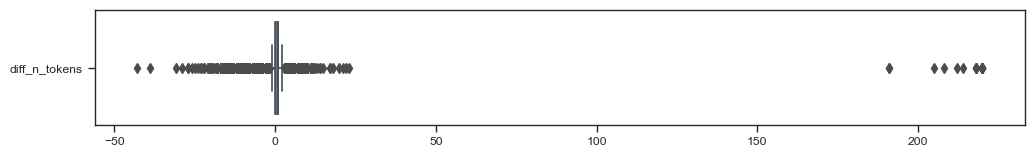

In [16]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")

savepath = OUTPUT_DIR / "analysis" / "boxplot_n_diff_tokens.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

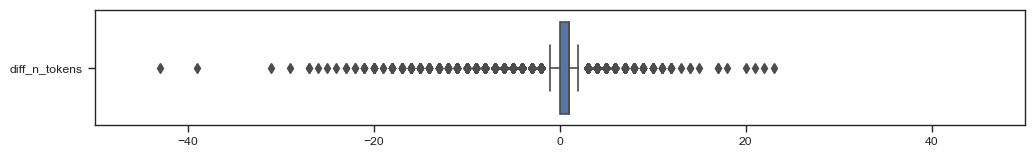

In [17]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")
plt.xlim(-50, 50);

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/analysis/diff_n_tokens_wrt_audio_length-ami.png`.


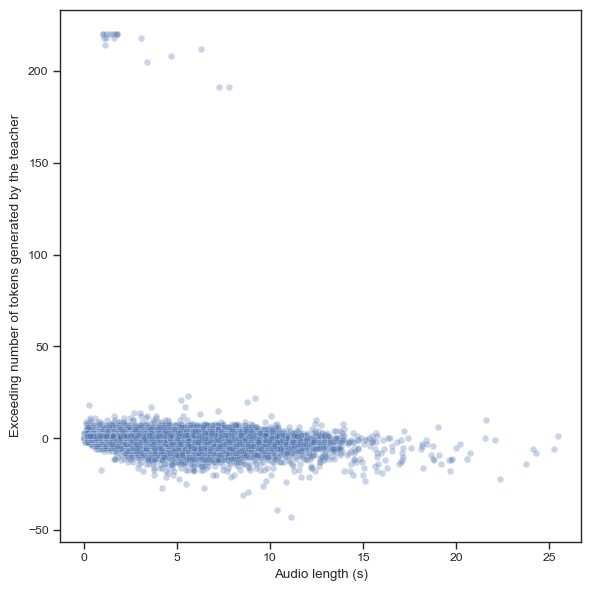

In [18]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df, x="audio_length", y="diff_n_tokens", alpha=0.3)
plt.tight_layout()

plt.xlabel("Audio length (s)")
plt.ylabel("Exceeding number of tokens generated by the teacher")

savepath = OUTPUT_DIR / "analysis" / "diff_n_tokens_wrt_audio_length-ami.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

## Criteria for filtering

### Exceeding tokens

In [19]:
THRESH_DELTA_N_TOKENS = df["diff_n_tokens"].mean() + 1.0 * df["diff_n_tokens"].std()
THRESH_DELTA_N_TOKENS

5.908813344284126

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/exceeding_tokens_filtering/exceeding_tokens_filter_pairplot.png`.


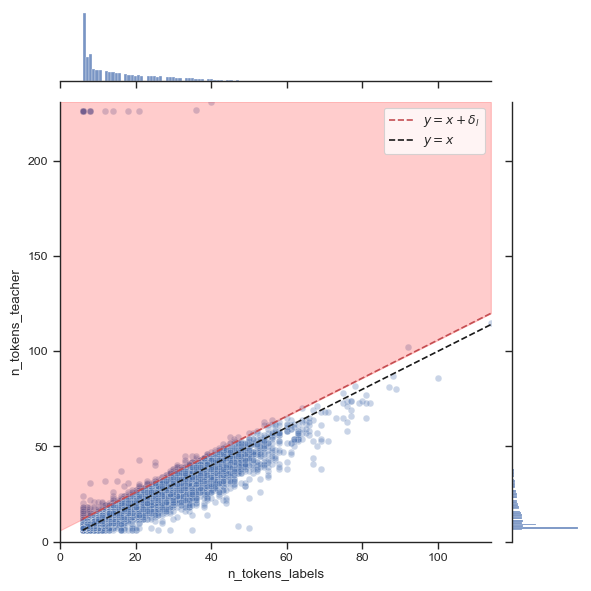

In [49]:
# Define the columns to use for the plot
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

# Define the value of delta
delta = THRESH_DELTA_N_TOKENS

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta_l$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Add legend and set axis limits
plt.legend()
plt.xlim(0, df[x_col].max())
plt.ylim(0, df[y_col].max())

# Adjust the layout and show the plot
plt.tight_layout()

# Save figure
savepath = OUTPUT_DIR / "exceeding_tokens_filtering" / "exceeding_tokens_filter_pairplot.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/exceeding_tokens_filtering/exceeding_tokens_filter_hist.png`.


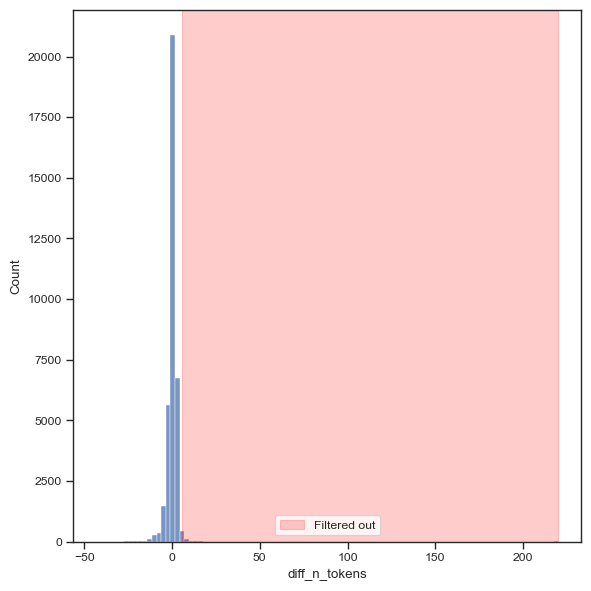

In [22]:
plt.figure(figsize=(6, 6))

# create a histogram of the "diff_n_tokens" column
sns.histplot(data=df, x="diff_n_tokens", bins=100)

# shade the area that will be filtered out in red
plt.axvspan(THRESH_DELTA_N_TOKENS, df["diff_n_tokens"].max(), color='red', alpha=0.2, label="Filtered out")

plt.legend()

# show the plot
plt.tight_layout()

# Save figure
savepath = OUTPUT_DIR / "exceeding_tokens_filtering" / "exceeding_tokens_filter_hist.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [24]:
df_candidates = df[df["high_diff_n_tokens"]]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 8
Reference:  'cause if we're gonna allow disjoint segments for example then how are we gonna know what's gonna be in context at any given time
Prediction:   So if we're going to allow disjoint segments for example, then how are we going to know what's going to be in context at any given time?

Idx = 69
Reference:  so then you'd start with all your utterances here and when you go up to get topic segments you go to here here here here here here here
Prediction:   so then you start with all your utterances here and when you go up to get topic segments you go to here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, he

In [25]:
if not load_from_pickle:
    list_idx_to_listen = df_candidates.index[:5]
    listen_to_audio(ds, list_idx_to_listen, pred_col="teacher_text")

In [26]:
eval_filter_criterion(df, df_filter=(df["diff_n_tokens"] <= THRESH_DELTA_N_TOKENS))

Number of rows before filtering: 36164
Total audio length before filtering: 1616.34 minutes
String edit metrics before filtering:
WER ortho (%)    41.49
Sub ortho (%)    28.38
Del ortho (%)    11.35
Ins ortho (%)     1.75
WER (%)          16.12
Sub (%)           5.12
Del (%)           9.10
Ins (%)           1.90
dtype: float64

Number of rows after filtering: 35853
Total audio length after filtering: 1591.76 minutes
String edit metrics after filtering:
WER ortho (%)    40.90
Sub ortho (%)    28.24
Del ortho (%)    11.48
Ins ortho (%)     1.18
WER (%)          15.67
Sub (%)           5.09
Del (%)           9.21
Ins (%)           1.38
dtype: float64

Number of rows removed: 311 (0.86 %)
Total audio length removed: 24.57 minutes (1.52 %)

String edit metrics difference:
WER ortho (%)    0.59
Sub ortho (%)    0.14
Del ortho (%)   -0.13
Ins ortho (%)    0.57
WER (%)          0.45
Sub (%)          0.03
Del (%)         -0.11
Ins (%)          0.52
dtype: float64

Relative string edit metrics d

**Observation:** Good criterion. Note that this also tackles the fact that the vanilla Whisper models tend to transcribe even the speeches in the background. By removing them from the training set, we hope to teach Whisper to only focus on the main speaker.

### gzip compression ratio

#### Analysis

In [27]:
# Quick example to confirm the intuition:
ref = "yeah so uh what we'll do is uh"
pred = "So, what we will do is, we will do is, we will do is, we will do is, we will do is,"

print("gzip ratios:")
print("- reference: ", compute_gzip_compression_ratio(ref))
print("- prediction: ", compute_gzip_compression_ratio(pred))

gzip ratios:
- reference:  0.6122448979591837
- prediction:  1.8444444444444446


Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/teacher_gzip_ratio_filtering/pairplot_gzip.png`.


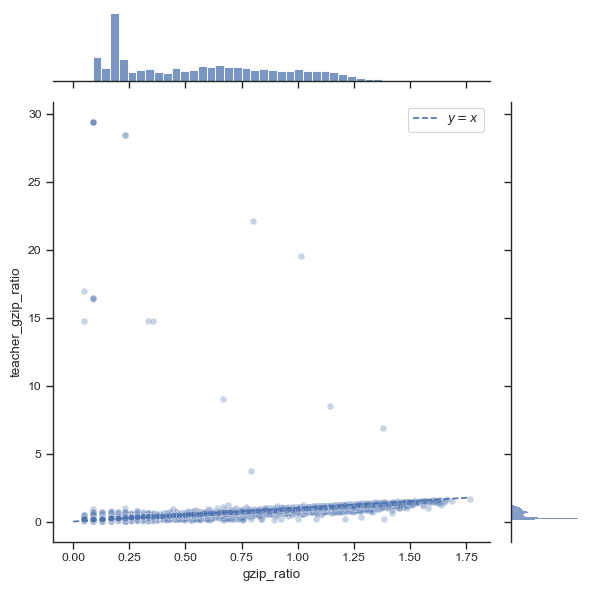

In [51]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.legend()
# plt.xlim(-1, line_max_coord)
# plt.ylim(-1, line_max_coord)
plt.tight_layout()

savepath = OUTPUT_DIR / "teacher_gzip_ratio_filtering" / "pairplot_gzip.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/teacher_gzip_ratio_filtering/boxplot_gzip_ratio.png`.


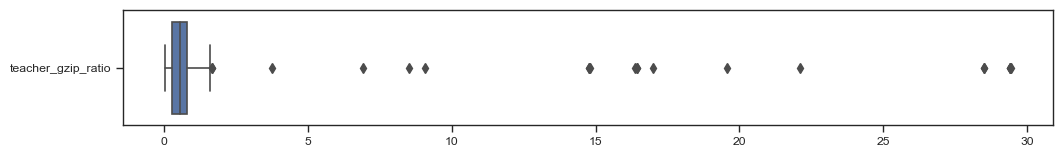

In [72]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["teacher_gzip_ratio"]], orient="h")

# Save figure:
savepath = OUTPUT_DIR / "teacher_gzip_ratio_filtering" / "boxplot_gzip_ratio.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

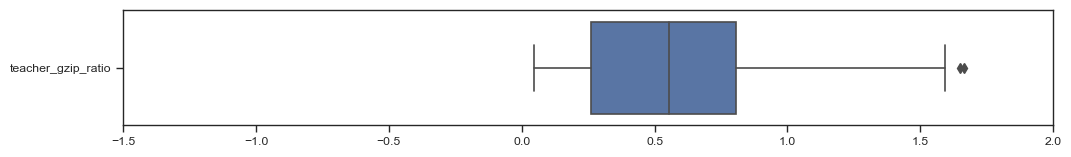

In [73]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["teacher_gzip_ratio"]], orient="h")
plt.xlim(-1.5, 2);

In [74]:
df["teacher_gzip_ratio"].describe().to_frame()

,teacher_gzip_ratio
count,36164.000000
mean,0.578493
std,0.551025
min,0.047619
25%,0.259259
50%,0.555556
75%,0.805195
max,29.433332


In [14]:
df["diff_n_tokens_50+"] = (df["diff_n_tokens"] > 50)
df["diff_n_tokens_50+"].value_counts() / len(df)

False    0.999475
True     0.000525
Name: diff_n_tokens_50+, dtype: float64

#### Using only the teacher gzip ratio

In [53]:
THRESH_TEACHER_GZIP = df["teacher_gzip_ratio"].mean() + 2 * df["teacher_gzip_ratio"].std()

THRESH_TEACHER_GZIP

1.6805433630943298

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/teacher_gzip_ratio_filtering/pairplot_gzip_filter.png`.


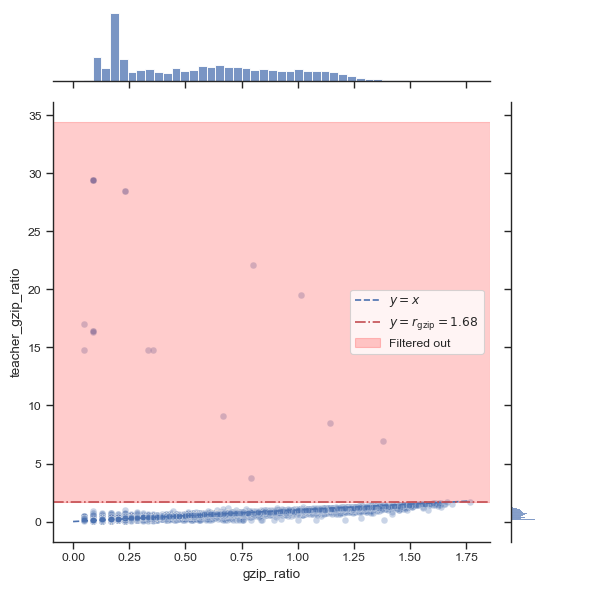

In [68]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'b--', label=r"$y=x$")
plt.axhline(y=THRESH_TEACHER_GZIP, ls="-.", c="r", label=r"$y = r_{\mathrm{gzip}} = "+f"{THRESH_TEACHER_GZIP:.2f}$")
plt.axhspan(ymin=THRESH_TEACHER_GZIP, ymax=df["teacher_gzip_ratio"].max()+5, color='red', alpha=0.2, label="Filtered out")
plt.legend()
plt.tight_layout()

savepath = OUTPUT_DIR / "teacher_gzip_ratio_filtering" / "pairplot_gzip_filter.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/teacher_gzip_ratio_filtering/hist_teacher_gzip_filter.png`.


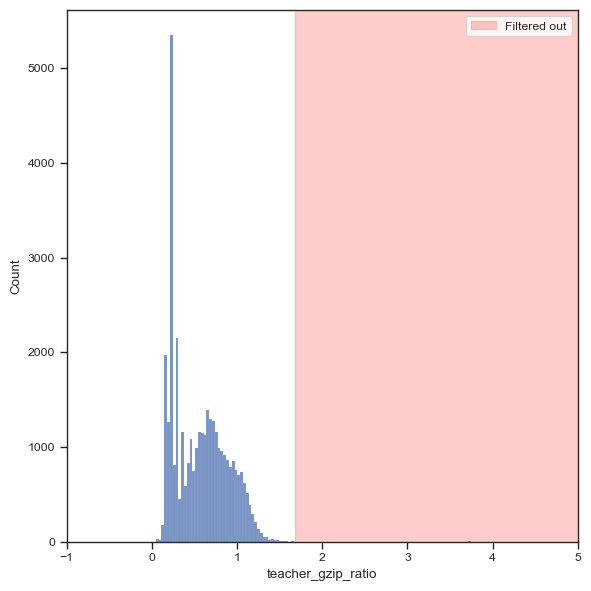

In [54]:
plt.figure(figsize=(6, 6))

# create a histogram of the "diff_n_tokens" column
sns.histplot(data=df, x="teacher_gzip_ratio")

# shade the area that will be filtered out in red
plt.axvspan(THRESH_TEACHER_GZIP, df["teacher_gzip_ratio"].max(), color='red', alpha=0.2, label="Filtered out")

plt.legend()
plt.xlim(-1, 5)

# show the plot
plt.tight_layout()

# Save figure:
savepath = OUTPUT_DIR  / "teacher_gzip_ratio_filtering" / "hist_teacher_gzip_filter.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [33]:
df_candidates = df[df["teacher_gzip_ratio"] > THRESH_TEACHER_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 69
Reference:  so then you'd start with all your utterances here and when you go up to get topic segments you go to here here here here here here here
Prediction:   so then you start with all your utterances here and when you go up to get topic segments you go to here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here

Idx = 5910
Reference:  well 'cause sometimes they go you know like that and then you're not really sure whether it's three times o

In [34]:
eval_filter_criterion(df, df_filter=(df["teacher_gzip_ratio"] <= THRESH_TEACHER_GZIP))

Number of rows before filtering: 36164
Total audio length before filtering: 1616.34 minutes
String edit metrics before filtering:
WER ortho (%)    41.49
Sub ortho (%)    28.38
Del ortho (%)    11.35
Ins ortho (%)     1.75
WER (%)          16.12
Sub (%)           5.12
Del (%)           9.10
Ins (%)           1.90
dtype: float64

Number of rows after filtering: 36145
Total audio length after filtering: 1615.49 minutes
String edit metrics after filtering:
WER ortho (%)    41.16
Sub ortho (%)    28.37
Del ortho (%)    11.36
Ins ortho (%)     1.44
WER (%)          15.83
Sub (%)           5.12
Del (%)           9.10
Ins (%)           1.61
dtype: float64

Number of rows removed: 19 (0.05 %)
Total audio length removed: 0.85 minutes (0.05 %)

String edit metrics difference:
WER ortho (%)    0.33
Sub ortho (%)    0.01
Del ortho (%)   -0.01
Ins ortho (%)    0.31
WER (%)          0.29
Sub (%)          0.00
Del (%)          0.00
Ins (%)          0.29
dtype: float64

Relative string edit metrics dif

#### Using the absolute difference in GZIP ratio with the ground-truth

In [35]:
THRESH_DIFF_GZIP = df["diff_gzip_ratio"].mean() + 1.0 * df["diff_gzip_ratio"].std()

THRESH_DIFF_GZIP

0.4790629409253597

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/analysis/gzip_ratio_filtering/diff_gzip_ratio/pairplot_gzip_filter.png`.


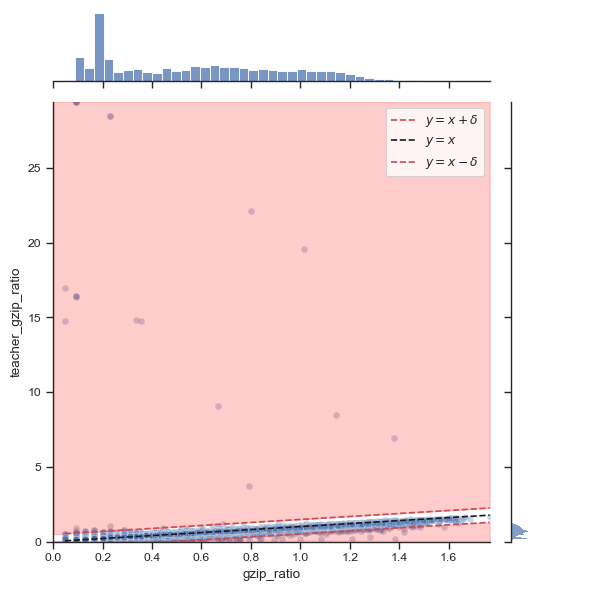

In [36]:
# Define the columns to use for the plot
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"


# Define the value of delta
delta = THRESH_DIFF_GZIP

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Plot the line y = x - delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() - delta, df[x_col].max() - delta], 'r--', label=r"$y = x - \delta$")

# Fill the area below the line y = x - delta
plt.fill_between([0, df[x_col].max()],
                 [0 - delta, df[x_col].max() - delta], df[y_col].min(),
                 alpha=0.2,
                 color="red")

# Add legend and set axis limits
plt.legend()
plt.xlim(0, df[x_col].max())
plt.ylim(0, df[y_col].max())

# Adjust the layout and show the plot
plt.tight_layout()

# Save figure:
savepath = OUTPUT_DIR  / "analysis" / "gzip_ratio_filtering" / "diff_gzip_ratio" / "pairplot_gzip_filter.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

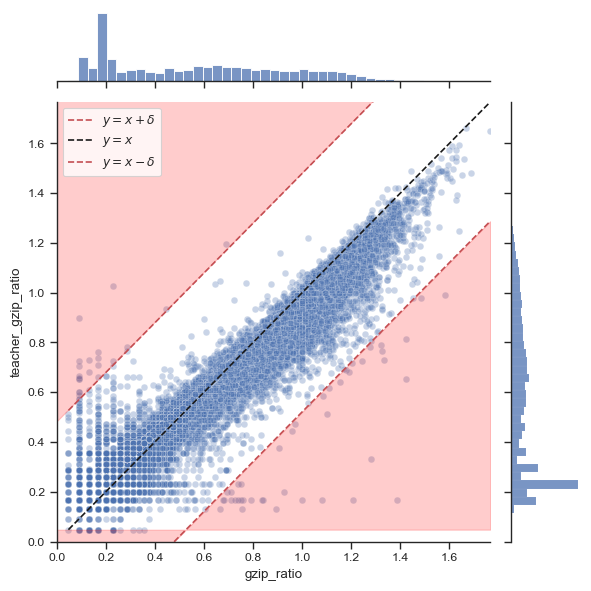

In [37]:
# Define the columns to use for the plot
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"


# Define the value of delta
delta = THRESH_DIFF_GZIP

# Create the joint plot
sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

# Plot the line y = x + delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() + delta, df[x_col].max() + delta], 'r--', label=r"$y = x + \delta$")

# Fill the area above the line y = x + delta
plt.fill_between([0, df[x_col].max()],
                 [0 + delta, df[x_col].max() + delta], df[y_col].max(),
                 alpha=0.2,
                 color="red")

# Plot the line y = x
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min(), df[x_col].max()], 'k--', label=r"$y = x$")

# Plot the line y = x - delta
plt.plot([df[x_col].min(), df[x_col].max()], [df[x_col].min() - delta, df[x_col].max() - delta], 'r--', label=r"$y = x - \delta$")

# Fill the area below the line y = x - delta
plt.fill_between([0, df[x_col].max()],
                 [0 - delta, df[x_col].max() - delta], df[y_col].min(),
                 alpha=0.2,
                 color="red")

# Add legend and set axis limits
plt.legend()
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.xlim(0, line_max_coord)
plt.ylim(0, line_max_coord)

# Adjust the layout and show the plot
plt.tight_layout()

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/analysis/gzip_ratio_filtering/diff_gzip_ratio/hist_gzip_filter.png`.


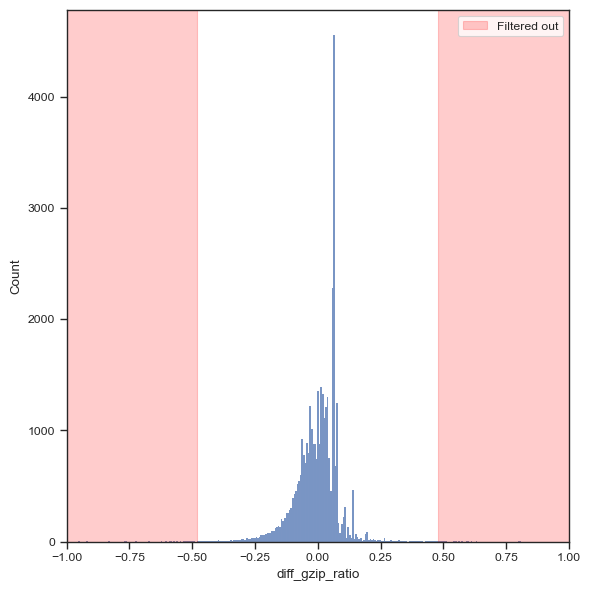

In [38]:
plt.figure(figsize=(6, 6))

# create a histogram of the "diff_n_tokens" column
sns.histplot(data=df, x="diff_gzip_ratio")

# shade the area that will be filtered out in red
plt.axvspan(THRESH_DIFF_GZIP, df["diff_gzip_ratio"].max(), color='red', alpha=0.2, label="Filtered out")
plt.axvspan(-THRESH_DIFF_GZIP, df["diff_gzip_ratio"].min(), color='red', alpha=0.2)

plt.legend()
plt.xlim(-1, 1)

# show the plot
plt.tight_layout()

# Save figure:
savepath = OUTPUT_DIR / "analysis" / "gzip_ratio_filtering" / "diff_gzip_ratio" / "hist_gzip_filter.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

In [39]:
df_candidates = df[df["diff_gzip_ratio"] > THRESH_DIFF_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 69
Reference:  so then you'd start with all your utterances here and when you go up to get topic segments you go to here here here here here here here
Prediction:   so then you start with all your utterances here and when you go up to get topic segments you go to here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here, here

Idx = 552
Reference:  no
Prediction:   You know, I don't know.

Idx = 5910
Reference:  well 'cause sometimes they go you know like

In [40]:
df_candidates = df[df["diff_gzip_ratio"] < - THRESH_DIFF_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 288
Reference:  is the uh is that the same as utterances that is that the same as utterances that
Prediction:   Is that the same as art trends?

Idx = 878
Reference:  i don't know who you see about that though
Prediction:   and

Idx = 957
Reference:  uh we looked that up and i for we looked that up and i forgot
Prediction:   We looked that up and I forgot.

Idx = 1752
Reference:  within th within the topic so like topic we had to when you say topic
Prediction:   within the topic.

Idx = 3437
Reference:  so like the top half one the bottom half the other
Prediction:   so

Idx = 3461
Reference:  but you may not be interested in the same series each time
Prediction:   the

Idx = 3467
Reference:  yeah we need to get on that pretty shortly i think
Prediction:   and

Idx = 3502
Reference:  well it doesn't it doesn't react to it being changed automatically
Prediction:   way doesn't

Idx = 3563
Reference:  um well i was gonna go to the gym at about three
Prediction:   and

Idx = 3657
Ref

In [41]:
eval_filter_criterion(df, df_filter=(df["diff_gzip_ratio"].abs() <= THRESH_DIFF_GZIP))

Number of rows before filtering: 36164
Total audio length before filtering: 1616.34 minutes
String edit metrics before filtering:
WER ortho (%)    41.49
Sub ortho (%)    28.38
Del ortho (%)    11.35
Ins ortho (%)     1.75
WER (%)          16.12
Sub (%)           5.12
Del (%)           9.10
Ins (%)           1.90
dtype: float64

Number of rows after filtering: 36079
Total audio length after filtering: 1611.08 minutes
String edit metrics after filtering:
WER ortho (%)    41.00
Sub ortho (%)    28.40
Del ortho (%)    11.21
Ins ortho (%)     1.38
WER (%)          15.63
Sub (%)           5.12
Del (%)           8.95
Ins (%)           1.57
dtype: float64

Number of rows removed: 85 (0.24 %)
Total audio length removed: 5.25 minutes (0.33 %)

String edit metrics difference:
WER ortho (%)    0.49
Sub ortho (%)   -0.02
Del ortho (%)    0.14
Ins ortho (%)    0.37
WER (%)          0.49
Sub (%)          0.00
Del (%)          0.15
Ins (%)          0.33
dtype: float64

Relative string edit metrics dif

### Timestamp overlaps

In [42]:
df["n_instant_tokens_norm"] = df["n_instant_tokens"] / df["n_tokens_teacher"]
df["max_subarray_length_norm"] = df["max_subarray_length"] / df["n_tokens_teacher"]

#### Using the normalized number of instant tokens

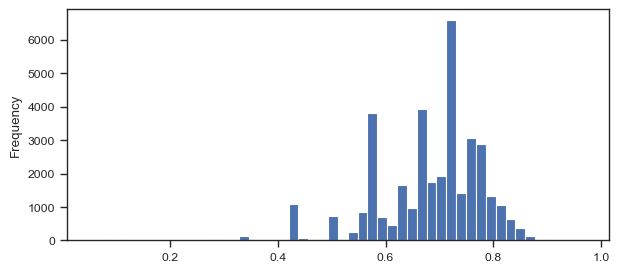

In [43]:
plt.figure(figsize=(7, 3))
df["n_instant_tokens_norm"].plot.hist(bins=50);

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/timestamp_based/instant_tokens/n_instant_tokens_norm_wrt_diff_n_tokens.png`.


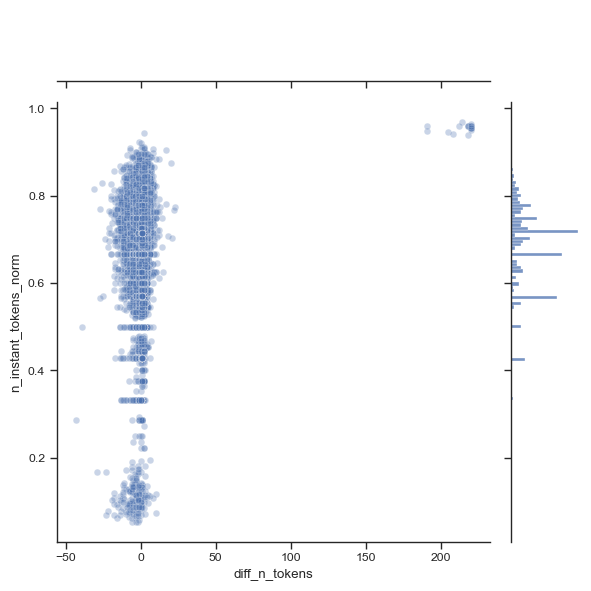

In [44]:
x_col = "diff_n_tokens"
y_col = "n_instant_tokens_norm"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3, height=6)
plt.tight_layout()

savepath = OUTPUT_DIR / "timestamp_based" / "instant_tokens" / "n_instant_tokens_norm_wrt_diff_n_tokens.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

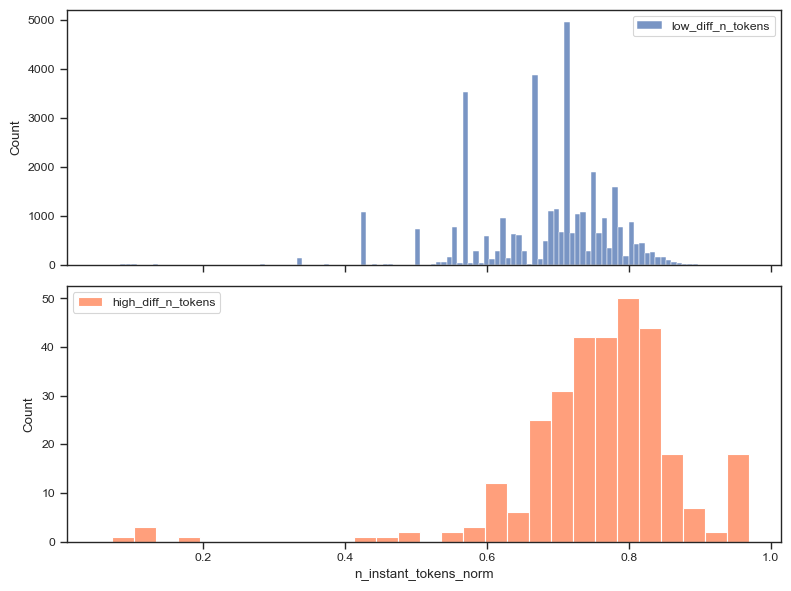

In [45]:
x_col = "n_instant_tokens_norm"
hue = "high_diff_n_tokens"

fig, axis = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
sns.histplot(data=df[~df["high_diff_n_tokens"]], x=x_col, label="low_diff_n_tokens", ax=axis[0])
axis[0].legend()
sns.histplot(data=df[df["high_diff_n_tokens"]], x=x_col, label="high_diff_n_tokens", color="coral", ax=axis[1])
axis[1].legend()
fig.tight_layout()

In [46]:
df_candidates = df[df["n_instant_tokens_norm"] > 0.95]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 5910
Reference:  well 'cause sometimes they go you know like that and then you're not really sure whether it's three times or four yeah
Prediction:   Because sometimes they go, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh, uh,

Idx = 8571
Reference:  no no no no no no no
Prediction:   No no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no

#### Using the normalized maximum subarray length

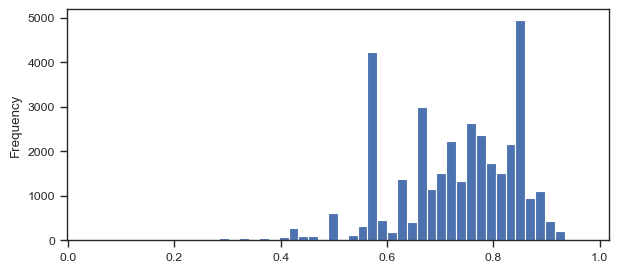

In [47]:
plt.figure(figsize=(7, 3))
df["max_subarray_length_norm"].plot.hist(bins=50);

Figure saved at `notebooks/outputs/8_1_best_kd/ami_100h/timestamp_based/max_subarray_length/max_subarray_length_norm_wrt_diff_n_tokens.png`.


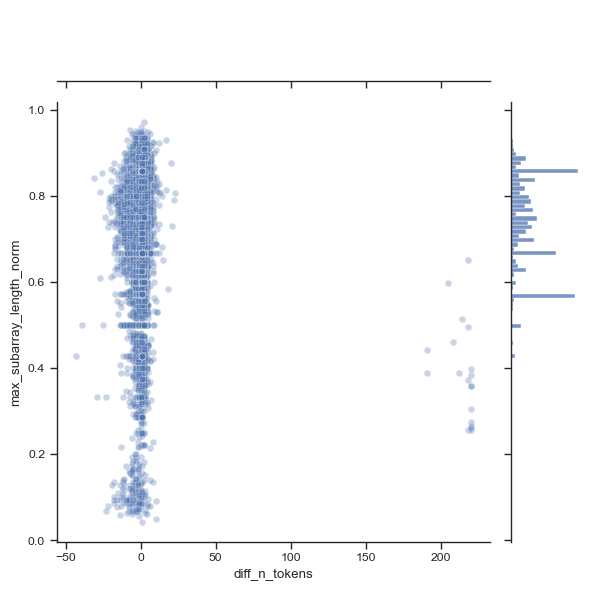

In [48]:
x_col = "diff_n_tokens"
y_col = "max_subarray_length_norm"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3, height=6)
plt.tight_layout()

savepath = OUTPUT_DIR / "timestamp_based" / "max_subarray_length" / "max_subarray_length_norm_wrt_diff_n_tokens.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

**Observation:** Not promising because we can't even discriminate the obvious hallucinations (the points with a high value of `diff_n_tokens` using `max_subarray_length_norm`).